In [1]:
# Switch path to root of project
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
current_folder = globals()['_dh'][0]
os.chdir(os.path.dirname(os.path.abspath(current_folder)))

%load_ext autoreload
%autoreload 2

In [2]:
import re
import math
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from einops import rearrange
from transformers import AutoTokenizer
from tokenizers.processors import TemplateProcessing

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Imports for Cosmos tokenizer
from huggingface_hub import snapshot_download
from cosmos_tokenizer.image_lib import ImageTokenizer

from nanofm.utils.checkpoint import load_model_from_safetensors
from nanofm.data.multimodal.simple_multimodal_dataset import SimpleMultimodalDataset
from nanofm.data.multimodal.masking import SimpleMultimodalMasking

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

/work/com-304/new_environment/anaconda3/envs/nanofm/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
# ╔══════════════════════════════════════════════════════════╗
# ║ Cell 1 – imports & Cosmos tokenizer helper               ║
# ╚══════════════════════════════════════════════════════════╝
import math, os, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from huggingface_hub import snapshot_download
from cosmos_tokenizer.image_lib import ImageTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

snapshot_download(
    repo_id="nvidia/Cosmos-0.1-Tokenizer-DI16x16",
    local_dir="/tmp/cosmos_tokenizer",
    local_dir_use_symlinks=False,                  
)

cosmos_tokenizer = ImageTokenizer(
    checkpoint_enc="/tmp/cosmos_tokenizer/encoder.jit",
    checkpoint_dec="/tmp/cosmos_tokenizer/decoder.jit",
).to(device).eval()

def token_ids_to_image(token_ids, to_pil=False):
    """
    (L,) LongTensor of Cosmos VQ tokens  →  CHW FloatTensor in [0,1]  (CPU).
    If to_pil=True returns a PIL.Image instead.
    """
    token_ids = token_ids.flatten()
    side = int(math.sqrt(token_ids.numel()))
    img_toks = token_ids.reshape(1, side, side).to(device)

    with torch.no_grad():
        img = cosmos_tokenizer.decode(img_toks)[0]         
    img = (img.clamp(-1, 1).float().cpu() + 1) / 2          

    return TF.to_pil_image(img) if to_pil else img

/work/com-304/new_environment/anaconda3/envs/nanofm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1212: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

autoencoder.jit:   0%|          | 0.00/169M [00:00<?, ?B/s]

decoder.jit:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

encoder.jit:   0%|          | 0.00/70.2M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

model_config.yaml:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

In [4]:
# -------------------------------------------------------------
# Visualising Penn-Action multimodal sample with 4M-style masks
# -------------------------------------------------------------
import math, torch, numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from cosmos_tokenizer.image_lib import ImageTokenizer

from nanofm.data.multimodal.masking import SimpleMultimodalMasking
from nanofm.data.multimodal.penn_action_multimodal_dataset import (
    PennActionMultimodalDataset
)
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- 1. helper: tokens → PIL image --------------------
snapshot_download(
    repo_id='nvidia/Cosmos-0.1-Tokenizer-DI16x16', 
    local_dir='/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16'
)
cosmos_tokenizer = ImageTokenizer(
    checkpoint_enc="/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/encoder.jit",
    checkpoint_dec="/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/decoder.jit"
).to(device)

def token_ids_to_image(token_ids, to_pil=False):
    """Cosmos token ids (L,) → tensor C,H,W (0-1) or PIL."""
    token_ids = token_ids.flatten()
    n = token_ids.numel()
    side = int(math.sqrt(n))
    img_toks = token_ids.reshape(1, side, side).to(device)

    with torch.no_grad():
        img = cosmos_tokenizer.decode(img_toks)[0]          # bfloat16, GPU
    print("Raw token values before clamping:", img_toks)
    img = img.clamp(-1, 1).to(torch.float32).cpu()          # ← cast + move
    img = (img + 1) / 2                                     # 0-1

    if to_pil:
        return TF.to_pil_image(img)
    return img    

# ---------- 2. helper: fetch modality + boolean mask ---------
def get_modality_with_mask(data_dict, mod_name, mask_type=None):
    tokens = data_dict["unmasked_data_dict"][mod_name].clone()
    L = tokens.shape[0]

    if mask_type == "input":
        m = data_dict["enc_modalities"] == modalities.index(mod_name)
        m = m & data_dict["enc_pad_mask"]
        idx = data_dict["enc_positions"][m]
    elif mask_type == "target":
        m = data_dict["dec_modalities"] == modalities.index(mod_name)
        m = m & data_dict["dec_pad_mask"]
        idx = data_dict["dec_positions"][m]
    elif mask_type is None:
        idx = torch.arange(L)
    else:
        raise ValueError(mask_type)

    mask = torch.zeros(L, dtype=torch.bool)
    mask[idx] = True
    return tokens, mask

def get_masked_image(img, mask, side=40):
    """Overlay mask (True=show) onto CHW image tensor (0-1)."""
    mask = mask.reshape(1, 1, side, side).float()
    mask = F.interpolate(mask, (img.shape[1], img.shape[2]), mode="nearest")[0,0]
    img = img.clone()
    img[:, ~mask.bool()] = 0
    return img.permute(1,2,0)

# ---------- 4. plotting routine -----------------------------------------
def plot_data_dict_with_mask(data_dict, mask_type=None):
    # caption ----------------------------------------------------------------
    tok, mask = get_modality_with_mask(data_dict, "captions", mask_type)
    cap_visible = mask.sum().item()
    show_ids = tok.clone()
    show_ids[~mask] = dataset.text_tok.pad_token_id
    print("Caption:", dataset.text_tok.decode(show_ids))

    # grid -------------------------------------------------------------------
    fig = plt.figure(figsize=(9, 3))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.2)

    # RGB --------------------------------------------------------------------
    tok, mask_rgb = get_modality_with_mask(data_dict, "tok_rgb", mask_type)
    grid[0].imshow(get_masked_image(token_ids_to_image(tok), mask_rgb, side=40))
    grid[0].set_title("RGB")

    # layout -----------------------------------------------------------------
    for ax in grid:
        ax.axis("off")
    plt.show()

    # ---------- print stats + coords tensor ---------------------------------
    # grab coords and its mask (no graphics here, just numbers)
    coords, mask_coords = get_modality_with_mask(data_dict, "coords", mask_type)

    print(f"\nRaw coords tensor  (shape={tuple(coords.shape)}):\n{coords.cpu()}")
    if mask_type is not None:
        # keep only the coordinates that are currently visible
        visible_coords = coords[mask_coords]
        print(f"\nVisible coords ({visible_coords.numel()} values):\n{visible_coords.cpu()}")

        # summary counts -----------------------------------------------------
        print("\nToken visibility summary")
        print(f"  caption tokens : {cap_visible}")
        print(f"  tok_rgb tokens : {mask_rgb.sum().item()}")
        print(f"  coords tokens  : {mask_coords.sum().item()}")

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

autoencoder.jit:   0%|          | 0.00/169M [00:00<?, ?B/s]

encoder.jit:   0%|          | 0.00/70.2M [00:00<?, ?B/s]

decoder.jit:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

model_config.yaml:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

In [5]:
# ---------- 3. configure masking + dataset -------------------
modalities   = ["tok_rgb", "captions", "coords"]
vocab_sizes  = [8192,50260, 8192]   # coords dummy = 8192
max_seq_lens = [1600, 256, 39]

In [6]:
mask_transform = SimpleMultimodalMasking(
    modalities       = modalities,
    vocab_sizes      = vocab_sizes,
    max_seq_lens     = max_seq_lens,
    input_alphas     = [1.,1.,1.],
    target_alphas    = [1.,1.,1.],
    input_tokens_range  = (1,128),
    target_tokens_range = (1,128),
    overlap_vocab    = True,
    overlap_posembs  = True,
    include_unmasked_data_dict = True,
)

In [7]:
dataset = PennActionMultimodalDataset(
    root_dir = "/work/com-304/CFT/output/",
    split    = "train",
    modalities = modalities,
    sample_from_k_augmentations = 1,
    text_tokenizer_path = "gpt2",
    text_max_length     = 256,
    transforms          = mask_transform,
)

########## Original (no masks) ##########
Caption: [SOS]a baseball player is getting ready to hit the ball[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD

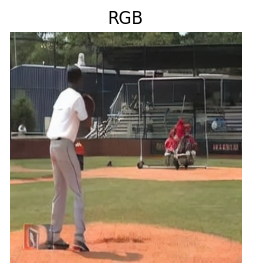


Raw coords tensor  (shape=(39,)):
tensor([5260, 5247, 4972, 5464, 5298, 5477, 5413, 5074, 5010, 5311, 4965, 5304,
        4889, 4906, 5264, 5221, 5784, 5784, 5435, 5486, 6092, 6143, 6996, 7005,
        7789, 7747, 8191, 8191, 4095, 8191, 4095, 8191, 4095, 8191, 4095, 8191,
        8191, 8191, 8191])


 ########## Encoder INPUT ##########
Caption: [SOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD] hit[PAD][PAD][EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][

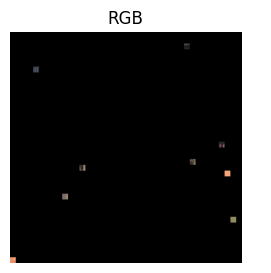


Raw coords tensor  (shape=(39,)):
tensor([5260, 5247, 4972, 5464, 5298, 5477, 5413, 5074, 5010, 5311, 4965, 5304,
        4889, 4906, 5264, 5221, 5784, 5784, 5435, 5486, 6092, 6143, 6996, 7005,
        7789, 7747, 8191, 8191, 4095, 8191, 4095, 8191, 4095, 8191, 4095, 8191,
        8191, 8191, 8191])

Visible coords (39 values):
tensor([5260, 5247, 4972, 5464, 5298, 5477, 5413, 5074, 5010, 5311, 4965, 5304,
        4889, 4906, 5264, 5221, 5784, 5784, 5435, 5486, 6092, 6143, 6996, 7005,
        7789, 7747, 8191, 8191, 4095, 8191, 4095, 8191, 4095, 8191, 4095, 8191,
        8191, 8191, 8191])

Token visibility summary
  caption tokens : 37
  tok_rgb tokens : 9
  coords tokens  : 39


 ########## Decoder TARGET ##########
Caption: [PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][P

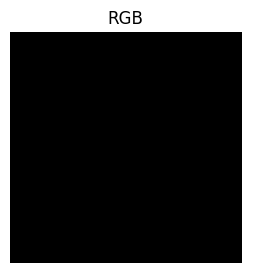


Raw coords tensor  (shape=(39,)):
tensor([5260, 5247, 4972, 5464, 5298, 5477, 5413, 5074, 5010, 5311, 4965, 5304,
        4889, 4906, 5264, 5221, 5784, 5784, 5435, 5486, 6092, 6143, 6996, 7005,
        7789, 7747, 8191, 8191, 4095, 8191, 4095, 8191, 4095, 8191, 4095, 8191,
        8191, 8191, 8191])

Visible coords (0 values):
tensor([], dtype=torch.int64)

Token visibility summary
  caption tokens : 1
  tok_rgb tokens : 0
  coords tokens  : 0


In [14]:
data_dict = dataset[0]

print("#"*10, "Original (no masks)", "#"*10)
plot_data_dict_with_mask(data_dict)

print("\n\n", "#"*10, "Encoder INPUT", "#"*10)
plot_data_dict_with_mask(data_dict, mask_type="input")

print("\n\n", "#"*10, "Decoder TARGET", "#"*10)
plot_data_dict_with_mask(data_dict, mask_type="target")

tok_rgb shape: torch.Size([1600])
✅ no negatives
Raw token values before clamping: tensor([[[32995, 40207, 22298,  ..., 48466, 56166, 55189],
         [31213, 60174, 10631,  ..., 19727, 29917, 14542],
         [22816, 40926, 37828,  ..., 21423, 36646, 21423],
         ...,
         [26440, 37800, 27371,  ..., 35696, 29649, 16672],
         [30025, 45921, 20368,  ..., 29976, 35664, 41376],
         [21864, 55233, 19296,  ..., 45408, 14240, 43417]]], device='cuda:0')


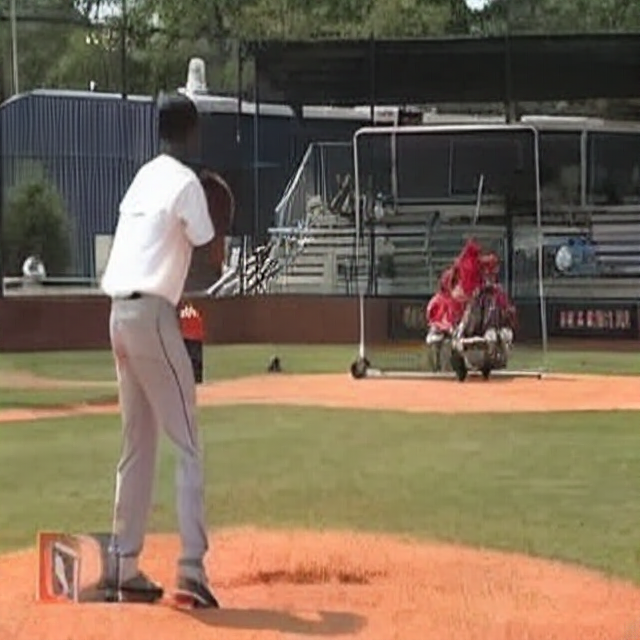

In [17]:
sample = dataset[0]

# if masking wrapper was applied
if "unmasked_data_dict" in sample:
    tok_rgb = sample["unmasked_data_dict"]["tok_rgb"]
else:
    tok_rgb = sample["tok_rgb"]

print("tok_rgb shape:", tok_rgb.shape)

# ---- negative-value check ----
if torch.any(tok_rgb < 0):
    print("⚠️  negative values:", tok_rgb[tok_rgb < 0])
else:
    print("✅ no negatives")

# ---- quick visualisation (Cosmos) ----
from PIL import Image
img = token_ids_to_image(tok_rgb, to_pil=True)
img.show()          # pops up a window or opens the default image viewer
